# Aproximación conexionista

Este cuaderno explora un enfoque alternativo y moderno para la clasificación de documentos, centrado en el paradigma conexionista mediante el uso de redes neuronales. A diferencia de la aproximación clásica basada en matrices de términos-documentos tradicionales, este enfoque aprovecha arquitecturas de aprendizaje profundo diseñadas para comprender la semántica y el contexto del lenguaje natural. El objetivo es proponer, implementar, entrenar y validar una solución de red neuronal que supere o complemente los métodos anteriores en la tarea de clasificar textos según su `journal_id`, evaluando su rendimiento con las mismas métricas rigurosas de la fase obligatoria.

## Imports y semilla

Esta celda describe las importaciones usadas en la siguiente celda (Celda 5):

- Importa utilidades de sistema y formatos (`Path`, `json`) y herramientas de texto (`re`, `random`).
- Carga `numpy` y `pandas` para manejo numérico y de dataframes.
- Trae funciones de `sklearn` para dividir el dataset y calcular métricas (`train_test_split`, `classification_report`, `confusion_matrix`, `accuracy_score`).
- Importa PyTorch (`torch`) y componentes (`nn`, `Dataset`, `DataLoader`) para definir, entrenar y evaluar modelos de deep learning.
- Importa librerías de visualización (`matplotlib.pyplot`, `seaborn`) para graficar resultados y matrices de confusión.

Estas importaciones preparan el entorno para el preprocesado, el entrenamiento y la evaluación del modelo conexionista con PyTorch.

In [10]:
from pathlib import Path
import json
import re
import random

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

Además, la siguiente celda define una función `seed_everything(seed=42)` que fija semillas en `random`, `numpy` y PyTorch
para asegurar reproducibilidad. También detecta y selecciona el `device` (`cuda` si hay GPU disponible, `cpu` en caso contrario).

In [11]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Carga del dataset y split

Lee el archivo `dataset.csv` procesado y prepara las etiquetas y textos para el modelo:

- Convierte `journal_id` a `int` y asegura que `text` no tenga valores nulos.
- `X` contiene los textos y `y_raw` las etiquetas originales.
- Se mapean las clases originales (por ejemplo `[1,2,3,5]`) a índices contiguos mediante `class2idx` para usar en PyTorch.
- Finalmente se hace un `train_test_split` estratificado para mantener la proporción de clases en ambos conjuntos.

In [12]:
df = pd.read_csv(Path("../data/processed/dataset.csv"))
df["journal_id"] = df["journal_id"].astype(int)
df["text"] = df["text"].fillna("").astype(str)

X = df["text"].values
y_raw = df["journal_id"].values

# Mapear clases {1,2,3,5} -> {0,1,2,3} para PyTorch
classes = sorted(df["journal_id"].unique().tolist())  # debería ser [1,2,3,5]
class2idx = {c:i for i,c in enumerate(classes)}
idx2class = {i:c for c,i in class2idx.items()}
y = np.array([class2idx[c] for c in y_raw])

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, np.arange(len(df)),
    test_size=0.2, random_state=42, stratify=y
)

classes, class2idx

([1, 2, 3, 5], {1: 0, 2: 1, 3: 2, 5: 3})

## Tokenización simple + vocabulario

Define una tokenización muy simple (palabras en ASCII) y construye el vocabulario usando SOLO el conjunto de entrenamiento:

- `TOKEN_RE` extrae tokens tipo palabras (incluye contracciones simples).
- `tokenize(text)` devuelve la lista de tokens en minúsculas.
- Se cuenta la frecuencia de tokens en `X_train` y se crean reservas `PAD` y `UNK`.
- Se limitan `max_vocab` y `min_freq` para controlar el tamaño del vocabulario; `stoi` mapea token->id.

In [13]:
TOKEN_RE = re.compile(r"[A-Za-z]+(?:'[A-Za-z]+)?")  # simple, para texto en inglés

def tokenize(text: str):
    return TOKEN_RE.findall(text.lower())

# Construir vocabulario SOLO con train
from collections import Counter
counter = Counter()
for t in X_train:
    counter.update(tokenize(t))

max_vocab = 30000
min_freq = 2

# Reservas
PAD = "<pad>"
UNK = "<unk>"

vocab = [PAD, UNK]
for tok, freq in counter.most_common():
    if freq < min_freq:
        continue
    vocab.append(tok)
    if len(vocab) >= max_vocab:
        break

stoi = {tok:i for i,tok in enumerate(vocab)}
pad_id = stoi[PAD]
unk_id = stoi[UNK]

len(vocab), vocab[:10]

(29174, ['<pad>', '<unk>', 'the', 'of', 'and', 'to', 'a', 'in', 'is', 'for'])

## Dataset + collate (padding + truncado)

Implementa la lógica para convertir textos a secuencias de IDs y preparar batches para PyTorch:

- `encode(text, max_len)` transforma un texto en una lista de IDs usando `stoi`, truncando a `max_len`. Si queda vacío, usa `unk_id`.
- `TextDataset` envuelve textos y etiquetas para poder indexar ejemplos.
- `collate_fn(batch)` realiza padding al máximo largo del batch: crea una matriz `x` con `pad_id`, calcula `lengths` y devuelve `(x, lengths, y)`.
- Se crean `DataLoader` para train y test con `collate_fn` y tamaños de batch apropiados.

In [14]:
def encode(text, max_len=256):
    ids = [stoi.get(tok, unk_id) for tok in tokenize(text)]
    if len(ids) == 0:
        ids = [unk_id]
    return ids[:max_len]

class TextDataset(Dataset):
    def __init__(self, texts, labels, max_len=256):
        self.texts = texts
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, i):
        return encode(self.texts[i], self.max_len), int(self.labels[i])

def collate_fn(batch):
    seqs, labels = zip(*batch)
    lengths = torch.tensor([len(s) for s in seqs], dtype=torch.long)
    max_len = max(lengths).item()
    x = torch.full((len(seqs), max_len), fill_value=pad_id, dtype=torch.long)
    for i, s in enumerate(seqs):
        x[i, :len(s)] = torch.tensor(s, dtype=torch.long)
    y = torch.tensor(labels, dtype=torch.long)
    return x, lengths, y

train_ds = TextDataset(X_train, y_train, max_len=256)
test_ds  = TextDataset(X_test, y_test, max_len=256)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_dl  = DataLoader(test_ds, batch_size=128, shuffle=False, collate_fn=collate_fn)

next(iter(train_dl))[0].shape


torch.Size([64, 256])

## Modelo: Embedding + mean pooling + MLP

Define una arquitectura sencilla para clasificación de texto basada en embeddings y pooling medio:

- `nn.Embedding` transforma IDs en vectores de dimensión `emb_dim`. Se usa `padding_idx=pad_id` para ignorar pads en el embedding.
- En `forward`, se aplica una máscara para ceroar embeddings de posiciones de padding y se promedia por longitud efectiva (mean pooling).
- El vector medio pasa por una MLP (`Linear -> ReLU -> Dropout -> Linear`) que produce `num_classes` logits.
- Se define `CrossEntropyLoss` y el optimizador Adam. Este modelo es eficiente y sirve como línea base conexionista.

In [15]:
class MeanPoolClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, num_classes, pad_id):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_id)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, num_classes)
        )
        self.pad_id = pad_id

    def forward(self, x, lengths):
        # x: [B, T]
        e = self.emb(x)  # [B, T, D]
        mask = (x != self.pad_id).unsqueeze(-1)  # [B, T, 1]
        e = e * mask
        summed = e.sum(dim=1)  # [B, D]
        denom = mask.sum(dim=1).clamp(min=1)  # [B, 1]
        mean = summed / denom
        logits = self.mlp(mean)
        return logits

num_classes = len(classes)
model = MeanPoolClassifier(
    vocab_size=len(vocab),
    emb_dim=128,
    hidden_dim=128,
    num_classes=num_classes,
    pad_id=pad_id
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

model

MeanPoolClassifier(
  (emb): Embedding(29174, 128, padding_idx=0)
  (mlp): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=4, bias=True)
  )
)

## Solución al desequilibrio de clases

El dataset presenta un **desequilibrio significativo** entre revistas. Para solucionarlo, se implementa un esquema de pesos de clase en la función de pérdida:

- Se calculan pesos inversamente proporcionales a la frecuencia de cada clase en el conjunto de entrenamiento.
- `CrossEntropyLoss` con parámetro `weight` penaliza más los errores en clases minoritarias.
- Se comparan los resultados con y sin balanceo para evaluar la mejora en clases minoritarias.

In [24]:
# Calcular pesos de clase para balanceo
from collections import Counter

# Contar frecuencia de cada clase en y_train
class_counts = Counter(y_train)
total_samples = len(y_train)

# Calcular pesos: inversamente proporcional a la frecuencia
# weight[i] = total_samples / (num_classes * count[i])
num_classes_balanced = len(classes)
class_weights = torch.zeros(num_classes_balanced)

for idx in range(num_classes_balanced):
    count = class_counts[idx]
    class_weights[idx] = total_samples / (num_classes_balanced * count)

print("Distribución de clases en entrenamiento:")
print("=" * 60)
for idx in range(num_classes_balanced):
    journal_id = idx2class[idx]
    count = class_counts[idx]
    weight = class_weights[idx].item()
    percentage = (count / total_samples) * 100
    print(f"Journal {journal_id} (idx={idx}): {count:5d} ejemplos ({percentage:5.2f}%) → peso={weight:.4f}")

print(f"\nPesos de clase calculados: {class_weights.numpy()}")

# Crear modelo balanceado
model_balanced = MeanPoolClassifier(
    vocab_size=len(vocab),
    emb_dim=128,
    hidden_dim=128,
    num_classes=num_classes_balanced,
    pad_id=pad_id
).to(device)

# Criterion con pesos de clase
criterion_balanced = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer_balanced = torch.optim.Adam(model_balanced.parameters(), lr=1e-3)

print(f"\n✓ Modelo con balanceo de clases creado")

Distribución de clases en entrenamiento:
Journal 1 (idx=0):   866 ejemplos ( 6.20%) → peso=4.0341
Journal 2 (idx=1):  1865 ejemplos (13.35%) → peso=1.8732
Journal 3 (idx=2):  7671 ejemplos (54.89%) → peso=0.4554
Journal 5 (idx=3):  3572 ejemplos (25.56%) → peso=0.9780

Pesos de clase calculados: [4.034065  1.8731904 0.4554165 0.9780235]

✓ Modelo con balanceo de clases creado


In [25]:
# Función de entrenamiento genérica para usar con cualquier criterion
def run_epoch_generic(model, dl, criterion_fn, optimizer_fn=None, train=True):
    model.train(train)
    total_loss = 0.0
    all_y, all_pred = [], []

    for x, lengths, yb in dl:
        x, lengths, yb = x.to(device), lengths.to(device), yb.to(device)
        logits = model(x, lengths)
        loss = criterion_fn(logits, yb)

        if train and optimizer_fn is not None:
            optimizer_fn.zero_grad()
            loss.backward()
            optimizer_fn.step()

        total_loss += loss.item() * yb.size(0)
        pred = torch.argmax(logits, dim=1)
        all_y.append(yb.detach().cpu().numpy())
        all_pred.append(pred.detach().cpu().numpy())

    all_y = np.concatenate(all_y)
    all_pred = np.concatenate(all_pred)
    avg_loss = total_loss / len(dl.dataset)
    acc = accuracy_score(all_y, all_pred)
    return avg_loss, acc, all_y, all_pred

# Entrenar modelo balanceado
best_acc_balanced = -1.0
best_state_balanced = None
patience_balanced = 10
no_improve_count_balanced = 0
max_epochs_balanced = 100

history_balanced = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': []
}

print("\nEntrenando modelo con balanceo de clases...")
print("=" * 60)

for epoch in range(1, max_epochs_balanced + 1):
    tr_loss, tr_acc, _, _ = run_epoch_generic(
        model_balanced, train_dl, criterion_balanced, optimizer_balanced, train=True
    )
    te_loss, te_acc, y_true_bal, y_pred_bal = run_epoch_generic(
        model_balanced, test_dl, criterion_balanced, train=False
    )

    history_balanced['train_loss'].append(tr_loss)
    history_balanced['train_acc'].append(tr_acc)
    history_balanced['test_loss'].append(te_loss)
    history_balanced['test_acc'].append(te_acc)

    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | test loss {te_loss:.4f} acc {te_acc:.4f}")

    if te_acc > best_acc_balanced:
        best_acc_balanced = te_acc
        best_state_balanced = {k: v.cpu().clone() for k, v in model_balanced.state_dict().items()}
        no_improve_count_balanced = 0
        print(f"  ✓ Nuevo mejor accuracy (balanceado): {best_acc_balanced:.4f}")
    else:
        no_improve_count_balanced += 1
        if no_improve_count_balanced >= patience_balanced:
            print(f"\nEarly stopping: sin mejora en {patience_balanced} epochs")
            break

print(f"\nEntrenamiento con balanceo completado. Mejor test accuracy: {best_acc_balanced:.4f}")


Entrenando modelo con balanceo de clases...
Epoch 01 | train loss 0.9832 acc 0.5693 | test loss 0.6746 acc 0.6488
  ✓ Nuevo mejor accuracy (balanceado): 0.6488
Epoch 02 | train loss 0.6116 acc 0.7022 | test loss 0.5834 acc 0.7086
  ✓ Nuevo mejor accuracy (balanceado): 0.7086
Epoch 03 | train loss 0.5240 acc 0.7496 | test loss 0.5641 acc 0.7376
  ✓ Nuevo mejor accuracy (balanceado): 0.7376
Epoch 04 | train loss 0.4699 acc 0.7739 | test loss 0.5528 acc 0.7476
  ✓ Nuevo mejor accuracy (balanceado): 0.7476
Epoch 05 | train loss 0.4219 acc 0.7972 | test loss 0.5624 acc 0.7550
  ✓ Nuevo mejor accuracy (balanceado): 0.7550
Epoch 06 | train loss 0.3748 acc 0.8242 | test loss 0.5598 acc 0.7341
Epoch 07 | train loss 0.3256 acc 0.8452 | test loss 0.5947 acc 0.7404
Epoch 08 | train loss 0.2814 acc 0.8685 | test loss 0.6503 acc 0.7430
Epoch 09 | train loss 0.2353 acc 0.8914 | test loss 0.7396 acc 0.7570
  ✓ Nuevo mejor accuracy (balanceado): 0.7570
Epoch 10 | train loss 0.1941 acc 0.9107 | test lo


COMPARACIÓN DE RESULTADOS

Accuracy General:
  Modelo SIN balanceo:  0.7705
  Modelo CON balanceo:  0.7570

F1-score por revista:
----------------------------------------------------------------------
Revista    Sin Balanceo    Con Balanceo    Mejora    
----------------------------------------------------------------------
Journal 1    0.947           0.933          ↓ -0.014
Journal 2    0.518           0.541          ↑ +0.024
Journal 3    0.844           0.837          ↓ -0.006
Journal 5    0.667           0.662          ↓ -0.004
----------------------------------------------------------------------
Macro Avg   0.744           0.744          ↓ -0.000


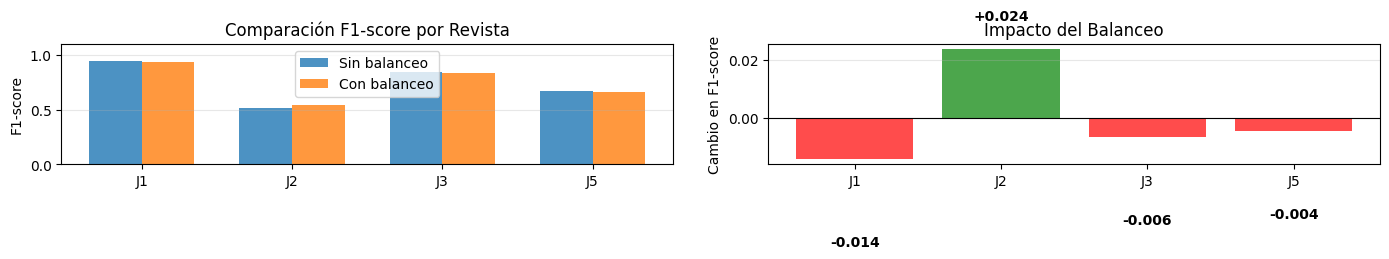

In [26]:
# Comparar resultados: Sin balanceo vs Con balanceo
print("\n" + "=" * 70)
print("COMPARACIÓN DE RESULTADOS")
print("=" * 70)

# Restaurar mejor modelo balanceado
model_balanced.load_state_dict(best_state_balanced)
_, _, y_true_bal, y_pred_bal = run_epoch_generic(model_balanced, test_dl, criterion_balanced, train=False)

# Calcular métricas por clase para ambos modelos
rep_original = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
rep_balanced = classification_report(y_true_bal, y_pred_bal, output_dict=True, zero_division=0)

print("\nAccuracy General:")
print(f"  Modelo SIN balanceo:  {best_acc:.4f}")
print(f"  Modelo CON balanceo:  {best_acc_balanced:.4f}")

print("\nF1-score por revista:")
print("-" * 70)
print(f"{'Revista':<10} {'Sin Balanceo':<15} {'Con Balanceo':<15} {'Mejora':<10}")
print("-" * 70)

for idx in range(num_classes_balanced):
    journal_id = idx2class[idx]
    idx_str = str(idx)
    
    f1_orig = rep_original.get(idx_str, {}).get('f1-score', 0)
    f1_bal = rep_balanced.get(idx_str, {}).get('f1-score', 0)
    improvement = f1_bal - f1_orig
    
    arrow = "↑" if improvement > 0 else "↓" if improvement < 0 else "→"
    print(f"Journal {journal_id:<3} {f1_orig:>6.3f}          {f1_bal:>6.3f}          {arrow} {improvement:+.3f}")

print("-" * 70)
print(f"{'Macro Avg':<10} {rep_original['macro avg']['f1-score']:>6.3f}          "
      f"{rep_balanced['macro avg']['f1-score']:>6.3f}          "
      f"{'↑' if rep_balanced['macro avg']['f1-score'] > rep_original['macro avg']['f1-score'] else '↓'} "
      f"{rep_balanced['macro avg']['f1-score'] - rep_original['macro avg']['f1-score']:+.3f}")

# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# F1-score por clase
x = np.arange(len(classes))
width = 0.35
f1_orig = [rep_original.get(str(class2idx[j]), {}).get('f1-score', 0) for j in classes]
f1_bal = [rep_balanced.get(str(class2idx[j]), {}).get('f1-score', 0) for j in classes]

axes[0].bar(x - width/2, f1_orig, width, label='Sin balanceo', alpha=0.8, color='#1f77b4')
axes[0].bar(x + width/2, f1_bal, width, label='Con balanceo', alpha=0.8, color='#ff7f0e')
axes[0].set_ylabel('F1-score')
axes[0].set_title('Comparación F1-score por Revista')
axes[0].set_xticks(x)
axes[0].set_xticklabels([f'J{j}' for j in classes])
axes[0].legend()
axes[0].set_ylim([0, 1.1])
axes[0].grid(True, axis='y', alpha=0.3)

# Mejora absoluta
improvement_vals = np.array(f1_bal) - np.array(f1_orig)
colors_imp = ['green' if i > 0 else 'red' if i < 0 else 'gray' for i in improvement_vals]

axes[1].bar(x, improvement_vals, color=colors_imp, alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1].set_ylabel('Cambio en F1-score')
axes[1].set_title('Impacto del Balanceo')
axes[1].set_xticks(x)
axes[1].set_xticklabels([f'J{j}' for j in classes])
axes[1].grid(True, axis='y', alpha=0.3)

for i, v in enumerate(improvement_vals):
    axes[1].text(i, v + 0.01 if v > 0 else v - 0.03, f'{v:+.3f}', 
                ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

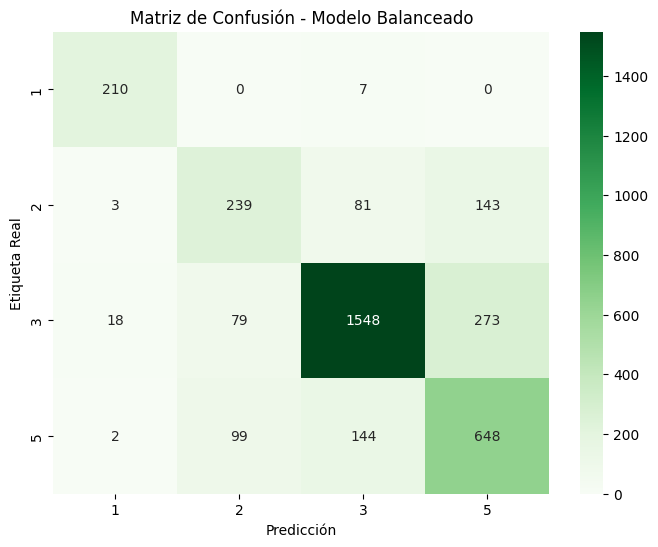


Reporte de clasificación del modelo balanceado:
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       217
           1       0.57      0.51      0.54       466
           2       0.87      0.81      0.84      1918
           3       0.61      0.73      0.66       893

    accuracy                           0.76      3494
   macro avg       0.74      0.75      0.74      3494
weighted avg       0.77      0.76      0.76      3494



In [27]:
# Matriz de confusión del modelo balanceado
cm_balanced = confusion_matrix(y_true_bal, y_pred_bal)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_balanced, annot=True, fmt="d", cmap="Greens", 
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión - Modelo Balanceado")
plt.show()

print("\nReporte de clasificación del modelo balanceado:")
print("=" * 60)
print(classification_report(y_true_bal, y_pred_bal, zero_division=0))

In [28]:
# Decidir cuál modelo usar como "mejor" basado en macro F1-score
macro_f1_original = rep_original['macro avg']['f1-score']
macro_f1_balanced = rep_balanced['macro avg']['f1-score']

if macro_f1_balanced > macro_f1_original:
    print("\n" + "=" * 70)
    print("✓ El modelo CON balanceo es superior (mejor macro F1-score)")
    print("=" * 70)
    print(f"Macro F1: {macro_f1_balanced:.4f} vs {macro_f1_original:.4f}")
    
    # Actualizar variables para usar el modelo balanceado
    best_model_final = model_balanced
    best_state_final = best_state_balanced
    best_acc_final = best_acc_balanced
    y_true_final = y_true_bal
    y_pred_final = y_pred_bal
    rep_final = rep_balanced
    cm_final = cm_balanced
    model_type = "balanced"
else:
    print("\n" + "=" * 70)
    print("✓ El modelo SIN balanceo es superior")
    print("=" * 70)
    print(f"Macro F1: {macro_f1_original:.4f} vs {macro_f1_balanced:.4f}")
    
    # Mantener modelo original
    best_model_final = model
    best_state_final = best_state
    best_acc_final = best_acc
    y_true_final = y_true
    y_pred_final = y_pred
    rep_final = rep_original
    cm_final = cm
    model_type = "original"

print(f"\nModelo seleccionado para guardar: {model_type}")


✓ El modelo SIN balanceo es superior
Macro F1: 0.7438 vs 0.7435

Modelo seleccionado para guardar: original


## Entrenamiento + evaluación

Contiene la función `run_epoch` y el bucle de entrenamiento con early stopping:

- `run_epoch(model, dl, train=True)` itera sobre un `DataLoader`, calcula logits, pérdida y, si `train`, realiza backprop y actualiza parámetros.
- Acumula predicciones y etiquetas para calcular accuracy y pérdida promedio por epoch.
- El bucle principal entrena hasta `max_epochs`, registra métricas en `history` y guarda el `best_state` cuando mejora la `test_acc`.
- Implementa `patience` para detener el entrenamiento si no hay mejora durante varias epochs (early stopping).

In [16]:
def run_epoch(model, dl, train=True):
    model.train(train)
    total_loss = 0.0
    all_y, all_pred = [], []

    for x, lengths, yb in dl:
        x, lengths, yb = x.to(device), lengths.to(device), yb.to(device)
        logits = model(x, lengths)
        loss = criterion(logits, yb)

        if train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * yb.size(0)
        pred = torch.argmax(logits, dim=1)
        all_y.append(yb.detach().cpu().numpy())
        all_pred.append(pred.detach().cpu().numpy())

    all_y = np.concatenate(all_y)
    all_pred = np.concatenate(all_pred)
    avg_loss = total_loss / len(dl.dataset)
    acc = accuracy_score(all_y, all_pred)
    return avg_loss, acc, all_y, all_pred

# Early stopping y tracking de métricas
best_acc = -1.0
best_state = None
patience = 10  # número de epochs sin mejora antes de parar
no_improve_count = 0
max_epochs = 100

# Para graficar
history = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': []
}

for epoch in range(1, max_epochs + 1):
    tr_loss, tr_acc, _, _ = run_epoch(model, train_dl, train=True)
    te_loss, te_acc, y_true, y_pred = run_epoch(model, test_dl, train=False)

    # Guardar métricas
    history['train_loss'].append(tr_loss)
    history['train_acc'].append(tr_acc)
    history['test_loss'].append(te_loss)
    history['test_acc'].append(te_acc)

    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | test loss {te_loss:.4f} acc {te_acc:.4f}")

    # Guardar mejor modelo
    if te_acc > best_acc:
        best_acc = te_acc
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        no_improve_count = 0
        print(f"  ✓ Nuevo mejor accuracy: {best_acc:.4f}")
    else:
        no_improve_count += 1
        if no_improve_count >= patience:
            print(f"\nEarly stopping: sin mejora en {patience} epochs")
            break

print(f"\nEntrenamiento completado. Mejor test accuracy: {best_acc:.4f}")

Epoch 01 | train loss 0.9424 acc 0.6104 | test loss 0.7090 acc 0.7129
  ✓ Nuevo mejor accuracy: 0.7129
Epoch 02 | train loss 0.6343 acc 0.7409 | test loss 0.6033 acc 0.7524
  ✓ Nuevo mejor accuracy: 0.7524
Epoch 03 | train loss 0.5422 acc 0.7812 | test loss 0.5779 acc 0.7627
  ✓ Nuevo mejor accuracy: 0.7627
Epoch 04 | train loss 0.4845 acc 0.8066 | test loss 0.5742 acc 0.7705
  ✓ Nuevo mejor accuracy: 0.7705
Epoch 05 | train loss 0.4333 acc 0.8298 | test loss 0.5667 acc 0.7653
Epoch 06 | train loss 0.3864 acc 0.8515 | test loss 0.5784 acc 0.7682
Epoch 07 | train loss 0.3388 acc 0.8710 | test loss 0.6134 acc 0.7647
Epoch 08 | train loss 0.2869 acc 0.8960 | test loss 0.6523 acc 0.7627
Epoch 09 | train loss 0.2439 acc 0.9123 | test loss 0.6862 acc 0.7527
Epoch 10 | train loss 0.1967 acc 0.9346 | test loss 0.7503 acc 0.7499
Epoch 11 | train loss 0.1565 acc 0.9504 | test loss 0.8130 acc 0.7481
Epoch 12 | train loss 0.1215 acc 0.9644 | test loss 0.9010 acc 0.7398
Epoch 13 | train loss 0.0933

## Visualización de resultados

Se plotean curvas de pérdida y accuracy para train y test almacenadas en `history`:

- La primera gráfica muestra la evolución de la pérdida (`train_loss`, `test_loss`).
- La segunda gráfica muestra el accuracy por epoch para ambos conjuntos.
- Al final se calcula `best_epoch` a partir de `history['test_acc']` para informar la mejor epoch observada.

Además, se observa la matriz de confusión.

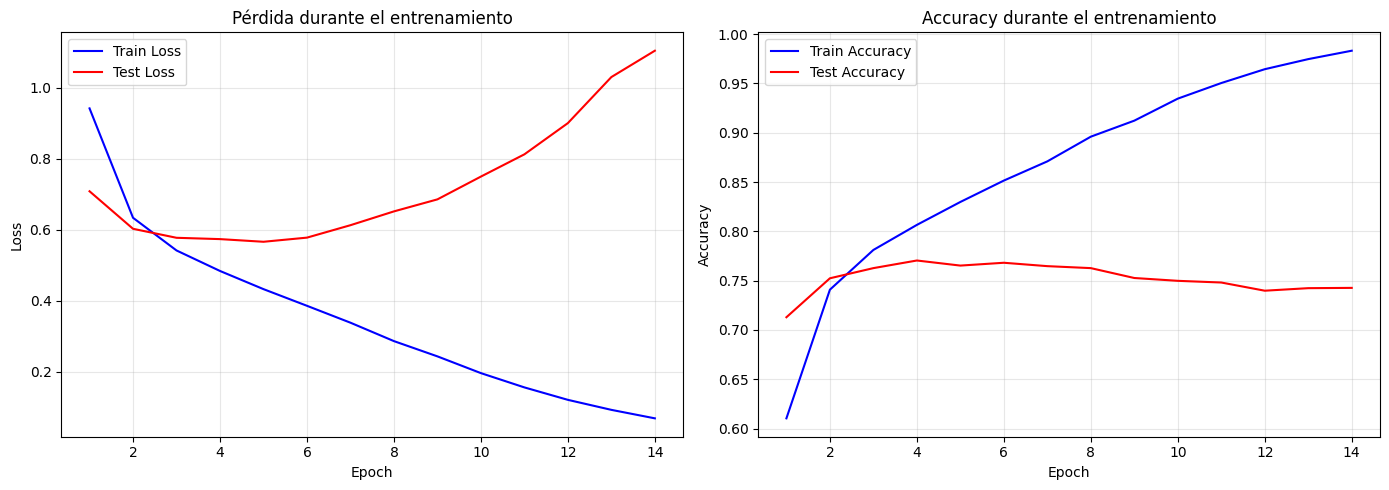


Mejor epoch: 4
Test accuracy: 0.7705
Test loss: 0.5742


In [17]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Gráfica de pérdida
epochs_range = range(1, len(history['train_loss']) + 1)
ax1.plot(epochs_range, history['train_loss'], 'b-', label='Train Loss')
ax1.plot(epochs_range, history['test_loss'], 'r-', label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Pérdida durante el entrenamiento')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Gráfica de accuracy
ax2.plot(epochs_range, history['train_acc'], 'b-', label='Train Accuracy')
ax2.plot(epochs_range, history['test_acc'], 'r-', label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy durante el entrenamiento')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Mostrar mejores resultados
best_epoch = np.argmax(history['test_acc']) + 1
print(f"\nMejor epoch: {best_epoch}")
print(f"Test accuracy: {history['test_acc'][best_epoch-1]:.4f}")
print(f"Test loss: {history['test_loss'][best_epoch-1]:.4f}")

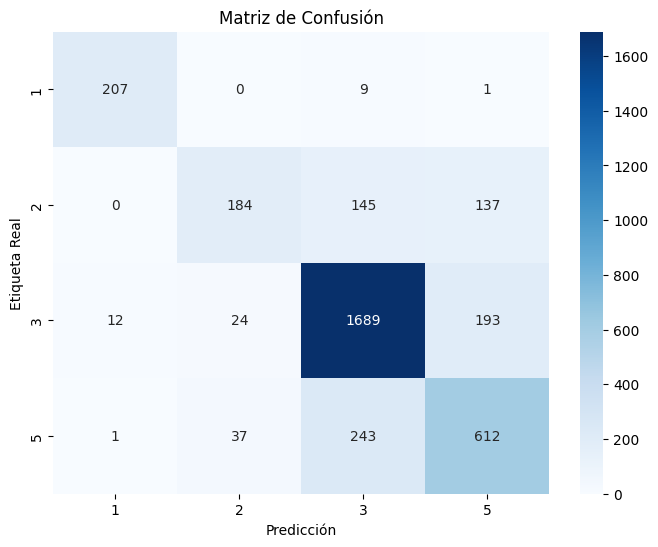

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       217
           1       0.75      0.39      0.52       466
           2       0.81      0.88      0.84      1918
           3       0.65      0.69      0.67       893

    accuracy                           0.77      3494
   macro avg       0.79      0.73      0.74      3494
weighted avg       0.77      0.77      0.76      3494

Matriz de Confusión:
 [[ 207    0    9    1]
 [   0  184  145  137]
 [  12   24 1689  193]
 [   1   37  243  612]]


In [18]:
# Restaurar mejor modelo
model.load_state_dict(best_state)
_, _, y_true, y_pred = run_epoch(model, test_dl, train=False)

# Reporte en ids 0..3
rep = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.title("Matriz de Confusión")
plt.show()

print(classification_report(y_true, y_pred, zero_division=0))
print("Matriz de Confusión:\n", cm)

## Análisis detallado por revista

Esta sección desglosa el rendimiento del modelo por cada clase (revista), permitiendo identificar fortalezas y debilidades específicas:

- **Métricas por clase**: gráfico de barras agrupadas que compara precision, recall y f1-score para cada revista.
- **Distribución de predicciones**: muestra cómo se distribuyen las predicciones correctas e incorrectas por clase.
- **Análisis de errores**: identifica qué revistas se confunden más entre sí.

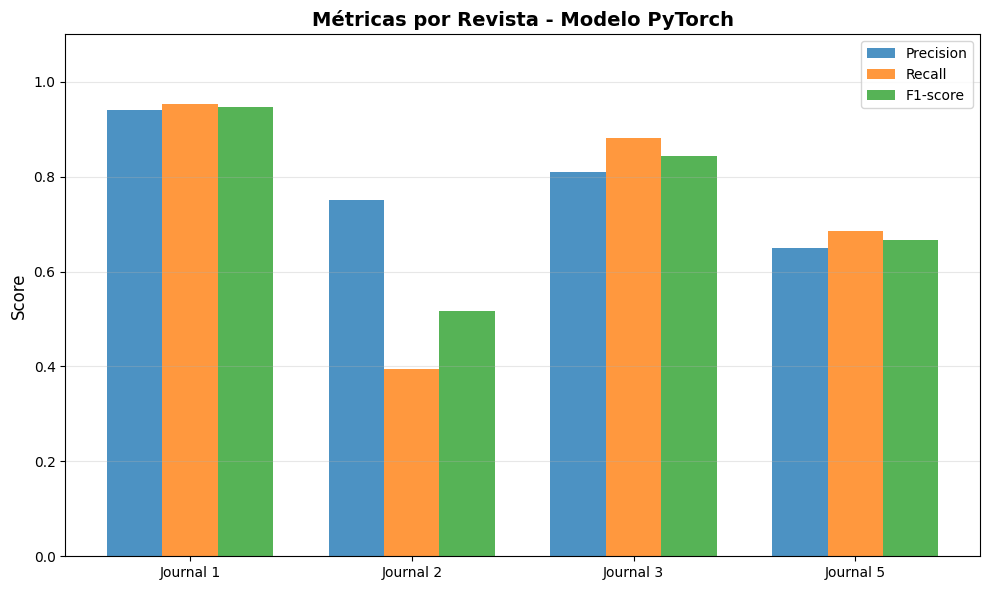


Resumen de métricas por revista:
Journal 1: Precision=0.941, Recall=0.954, F1=0.947
Journal 2: Precision=0.751, Recall=0.395, F1=0.518
Journal 3: Precision=0.810, Recall=0.881, F1=0.844
Journal 5: Precision=0.649, Recall=0.685, F1=0.667


In [19]:
# 1. Métricas por clase (Precision, Recall, F1-score)
fig, ax = plt.subplots(figsize=(10, 6))

# Extraer métricas por clase del reporte
metrics_data = {}
for class_id in classes:
    class_str = str(class2idx[class_id])  # Convertir a índice 0..3
    if class_str in rep:
        metrics_data[class_id] = {
            'precision': rep[class_str]['precision'],
            'recall': rep[class_str]['recall'],
            'f1-score': rep[class_str]['f1-score']
        }

# Preparar datos para graficar
x = np.arange(len(metrics_data))
width = 0.25
journal_ids = sorted(metrics_data.keys())
precision = [metrics_data[k]['precision'] for k in journal_ids]
recall = [metrics_data[k]['recall'] for k in journal_ids]
f1 = [metrics_data[k]['f1-score'] for k in journal_ids]

# Crear barras
ax.bar(x - width, precision, width, label='Precision', alpha=0.8, color='#1f77b4')
ax.bar(x, recall, width, label='Recall', alpha=0.8, color='#ff7f0e')
ax.bar(x + width, f1, width, label='F1-score', alpha=0.8, color='#2ca02c')

ax.set_ylabel('Score', fontsize=12)
ax.set_title('Métricas por Revista - Modelo PyTorch', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'Journal {k}' for k in journal_ids])
ax.legend()
ax.set_ylim([0, 1.1])
ax.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Mostrar tabla resumen
print("\nResumen de métricas por revista:")
print("=" * 60)
for journal_id in journal_ids:
    m = metrics_data[journal_id]
    print(f"Journal {journal_id}: Precision={m['precision']:.3f}, Recall={m['recall']:.3f}, F1={m['f1-score']:.3f}")


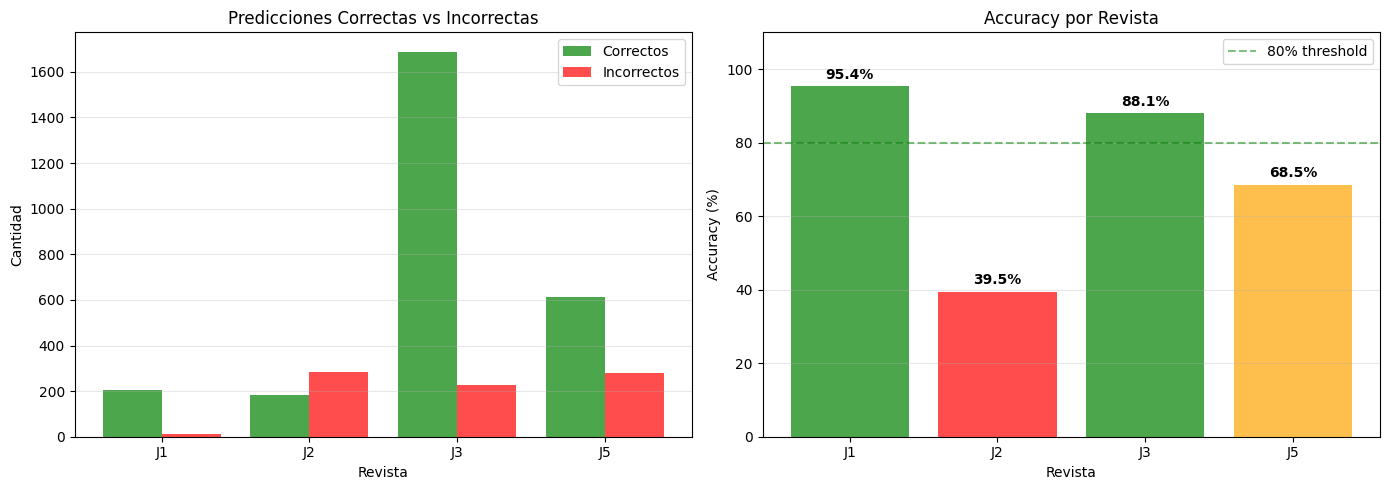

In [20]:
# 2. Distribución de predicciones correctas vs incorrectas por revista
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Contar correctos e incorrectos por clase
correct_by_class = {}
incorrect_by_class = {}
total_by_class = {}

for true_idx, pred_idx in zip(y_true, y_pred):
    true_journal = idx2class[true_idx]
    
    if true_journal not in total_by_class:
        total_by_class[true_journal] = 0
        correct_by_class[true_journal] = 0
        incorrect_by_class[true_journal] = 0
    
    total_by_class[true_journal] += 1
    
    if true_idx == pred_idx:
        correct_by_class[true_journal] += 1
    else:
        incorrect_by_class[true_journal] += 1

# Gráfico 1: Número absoluto de correctos vs incorrectos
x_pos = np.arange(len(classes))
correct_counts = [correct_by_class.get(j, 0) for j in classes]
incorrect_counts = [incorrect_by_class.get(j, 0) for j in classes]

axes[0].bar(x_pos - 0.2, correct_counts, 0.4, label='Correctos', color='green', alpha=0.7)
axes[0].bar(x_pos + 0.2, incorrect_counts, 0.4, label='Incorrectos', color='red', alpha=0.7)
axes[0].set_xlabel('Revista')
axes[0].set_ylabel('Cantidad')
axes[0].set_title('Predicciones Correctas vs Incorrectas')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([f'J{j}' for j in classes])
axes[0].legend()
axes[0].grid(True, axis='y', alpha=0.3)

# Gráfico 2: Porcentaje de accuracy por clase
accuracies = [correct_by_class.get(j, 0) / total_by_class.get(j, 1) * 100 for j in classes]
colors = ['green' if acc >= 80 else 'orange' if acc >= 60 else 'red' for acc in accuracies]

axes[1].bar(x_pos, accuracies, color=colors, alpha=0.7)
axes[1].axhline(y=80, color='green', linestyle='--', alpha=0.5, label='80% threshold')
axes[1].set_xlabel('Revista')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Accuracy por Revista')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([f'J{j}' for j in classes])
axes[1].set_ylim([0, 110])
axes[1].legend()
axes[1].grid(True, axis='y', alpha=0.3)

for i, v in enumerate(accuracies):
    axes[1].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


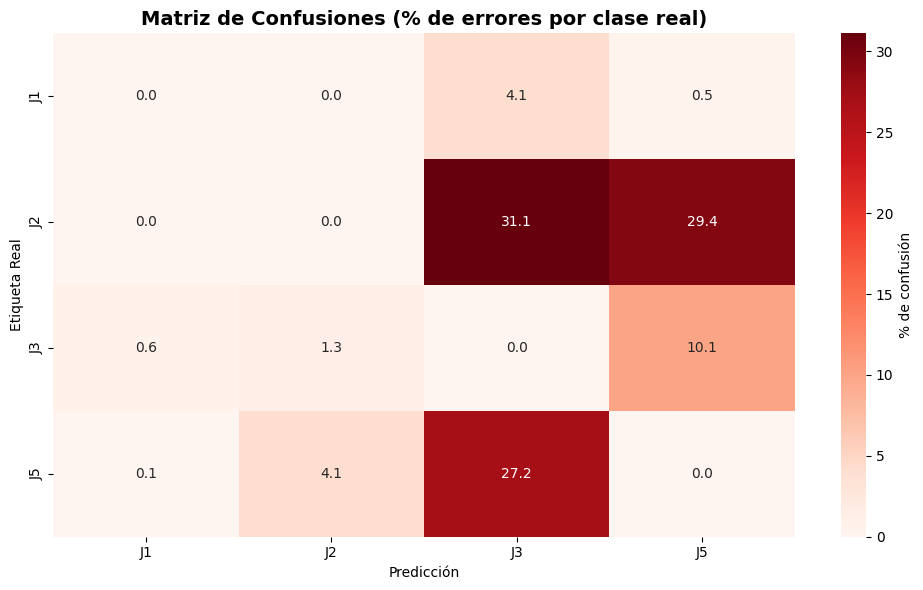


Confusiones más frecuentes:
Journal 5 → Journal 3: 243 errores (27.2% de J5)
Journal 3 → Journal 5: 193 errores (10.1% de J3)
Journal 2 → Journal 3: 145 errores (31.1% de J2)
Journal 2 → Journal 5: 137 errores (29.4% de J2)
Journal 5 → Journal 2: 37 errores (4.1% de J5)


In [21]:
# 3. Análisis de confusiones: ¿Qué revistas se confunden entre sí?
fig, ax = plt.subplots(figsize=(10, 6))

# Crear matriz de errores (sin la diagonal)
error_matrix = cm.copy()
np.fill_diagonal(error_matrix, 0)

# Normalizar por filas para ver porcentajes de confusión
error_percentages = error_matrix.astype(float)
for i in range(len(error_matrix)):
    row_sum = cm[i].sum()
    if row_sum > 0:
        error_percentages[i] = (error_matrix[i] / row_sum) * 100

# Crear heatmap de confusiones
sns.heatmap(error_percentages, annot=True, fmt='.1f', cmap='Reds', 
            xticklabels=[f'J{c}' for c in classes], 
            yticklabels=[f'J{c}' for c in classes],
            ax=ax, cbar_kws={'label': '% de confusión'})
ax.set_xlabel('Predicción')
ax.set_ylabel('Etiqueta Real')
ax.set_title('Matriz de Confusiones (% de errores por clase real)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Encontrar las confusiones más frecuentes
print("\nConfusiones más frecuentes:")
print("=" * 60)
confusions = []
for i in range(len(cm)):
    for j in range(len(cm)):
        if i != j and error_matrix[i, j] > 0:
            confusions.append((
                idx2class[i], 
                idx2class[j], 
                error_matrix[i, j], 
                error_percentages[i, j]
            ))

confusions.sort(key=lambda x: x[2], reverse=True)
for true_class, pred_class, count, pct in confusions[:5]:
    print(f"Journal {true_class} → Journal {pred_class}: {int(count)} errores ({pct:.1f}% de J{true_class})")


## Reporte, confusión, guardar modelo y errores

Después del entrenamiento se restaura el mejor estado y se evalúa el modelo en test para generar reportes y guardar resultados:

- Se calcula el `classification_report` y la `confusion_matrix` sobre las etiquetas indexadas (0..N-1).
- Se guardan métricas y metadatos en `../docs/pytorch/metrics.json` y el `state_dict` + vocab en `../models/pytorch/meanpool_mlp.pt`.
- Se exportan los errores (`errors.csv`) con las etiquetas originales (mapeadas de vuelta usando `idx2class`) para análisis posterior.

In [22]:
rep = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
print(classification_report(y_true, y_pred, zero_division=0))
print("Confusion matrix:\n", cm)

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       217
           1       0.75      0.39      0.52       466
           2       0.81      0.88      0.84      1918
           3       0.65      0.69      0.67       893

    accuracy                           0.77      3494
   macro avg       0.79      0.73      0.74      3494
weighted avg       0.77      0.77      0.76      3494

Confusion matrix:
 [[ 207    0    9    1]
 [   0  184  145  137]
 [  12   24 1689  193]
 [   1   37  243  612]]


In [29]:
OUT_DIR = Path("../docs/pytorch")
OUT_DIR.mkdir(parents=True, exist_ok=True)
MODELS_DIR = Path("../models/pytorch")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

# Guardar métricas (usando el mejor modelo final)
payload = {
    "model_type": model_type,  # "balanced" o "original"
    "classes_original": classes,            # [1,2,3,5]
    "class2idx": class2idx,
    "best_test_accuracy": float(best_acc_final),
    "macro_f1_score": float(rep_final['macro avg']['f1-score']),
    "classification_report": rep_final,
    "confusion_matrix": cm_final.tolist(),
    "vocab_size": len(vocab),
    "max_len": 256
}
with open(OUT_DIR / "metrics.json", "w", encoding="utf-8") as f:
    json.dump(payload, f, ensure_ascii=False, indent=2)

# Guardar modelo + vocab (mejor modelo final)
torch.save(
    {
        "model_state_dict": best_state_final,
        "model_type": model_type,
        "classes": classes,
        "class2idx": class2idx,
        "vocab": vocab,
        "pad_id": pad_id,
        "unk_id": unk_id,
        "class_weights": class_weights.tolist() if model_type == "balanced" else None
    },
    MODELS_DIR / f"best_model_{model_type}.pt"
)

# Guardar errores en CSV con etiquetas originales (1,2,3,5)
errors = df.iloc[idx_test].copy()
errors["y_true"] = [idx2class[i] for i in y_true_final]
errors["y_pred"] = [idx2class[i] for i in y_pred_final]
errors = errors[errors["y_true"] != errors["y_pred"]]
errors.to_csv(OUT_DIR / "errors.csv", index=False)

print(f"✓ Guardado: {OUT_DIR / 'metrics.json'}")
print(f"✓ Guardado: {MODELS_DIR / f'best_model_{model_type}.pt'}")
print(f"✓ Guardado: {OUT_DIR / 'errors.csv'} ({len(errors)} errores)")

OUT_DIR / "metrics.json", OUT_DIR / "errors.csv"

✓ Guardado: ..\docs\pytorch\metrics.json
✓ Guardado: ..\models\pytorch\best_model_original.pt
✓ Guardado: ..\docs\pytorch\errors.csv (802 errores)


(WindowsPath('../docs/pytorch/metrics.json'),
 WindowsPath('../docs/pytorch/errors.csv'))